#### Loading SAMPLE VID

In [183]:
from datetime import datetime
import os

now = datetime.now()
date = now.strftime("%Y_%m_%d")

In [212]:
font = "/Users/troydo42/Desktop/Body_Matrixes/Roboto-Bold.ttf"
sample_folder = "/Users/troydo42/Desktop/Body_Matrixes/samples"

left_file = "sample04.mp4"
right_file = "sample08.mp4"
min_accuracy = 0.9

output_folder = os.path.join("/Users/troydo42/Desktop/Body_Matrixes/", "outputs")

In [213]:
cd "$sample_folder"

/Users/troydo42/Desktop/Body_Matrixes/samples


In [214]:
ls

man.mp4       sample03.mp4  sample06.mp4* sample09.mp4*
sample01.mp4  sample04.mp4* sample07.mp4* sample10.mp4
sample02.mp4* sample05.mp4* sample08.mp4*


In [215]:
import os

left_video_path = os.path.join(sample_folder, left_file)
right_video_path = os.path.join(sample_folder, right_file)

In [216]:
### Loading Video
import os
import av
import math
import random
from torchvision.io import read_video
from torchvision.transforms.functional import to_pil_image

def load_video(video_path, rotate):
    video, audio, meta = read_video(video_path, pts_unit="sec", output_format="TCHW")
    frame_counts = len(video)
    fps = meta['video_fps']
    print(frame_counts, fps)
    sample_index = random.randrange(frame_counts)
    sample_frame = to_pil_image(video[sample_index])
    sample_frame = sample_frame.rotate(rotate, expand=True)
    return video, frame_counts, fps, sample_frame

69 29.8804780876494


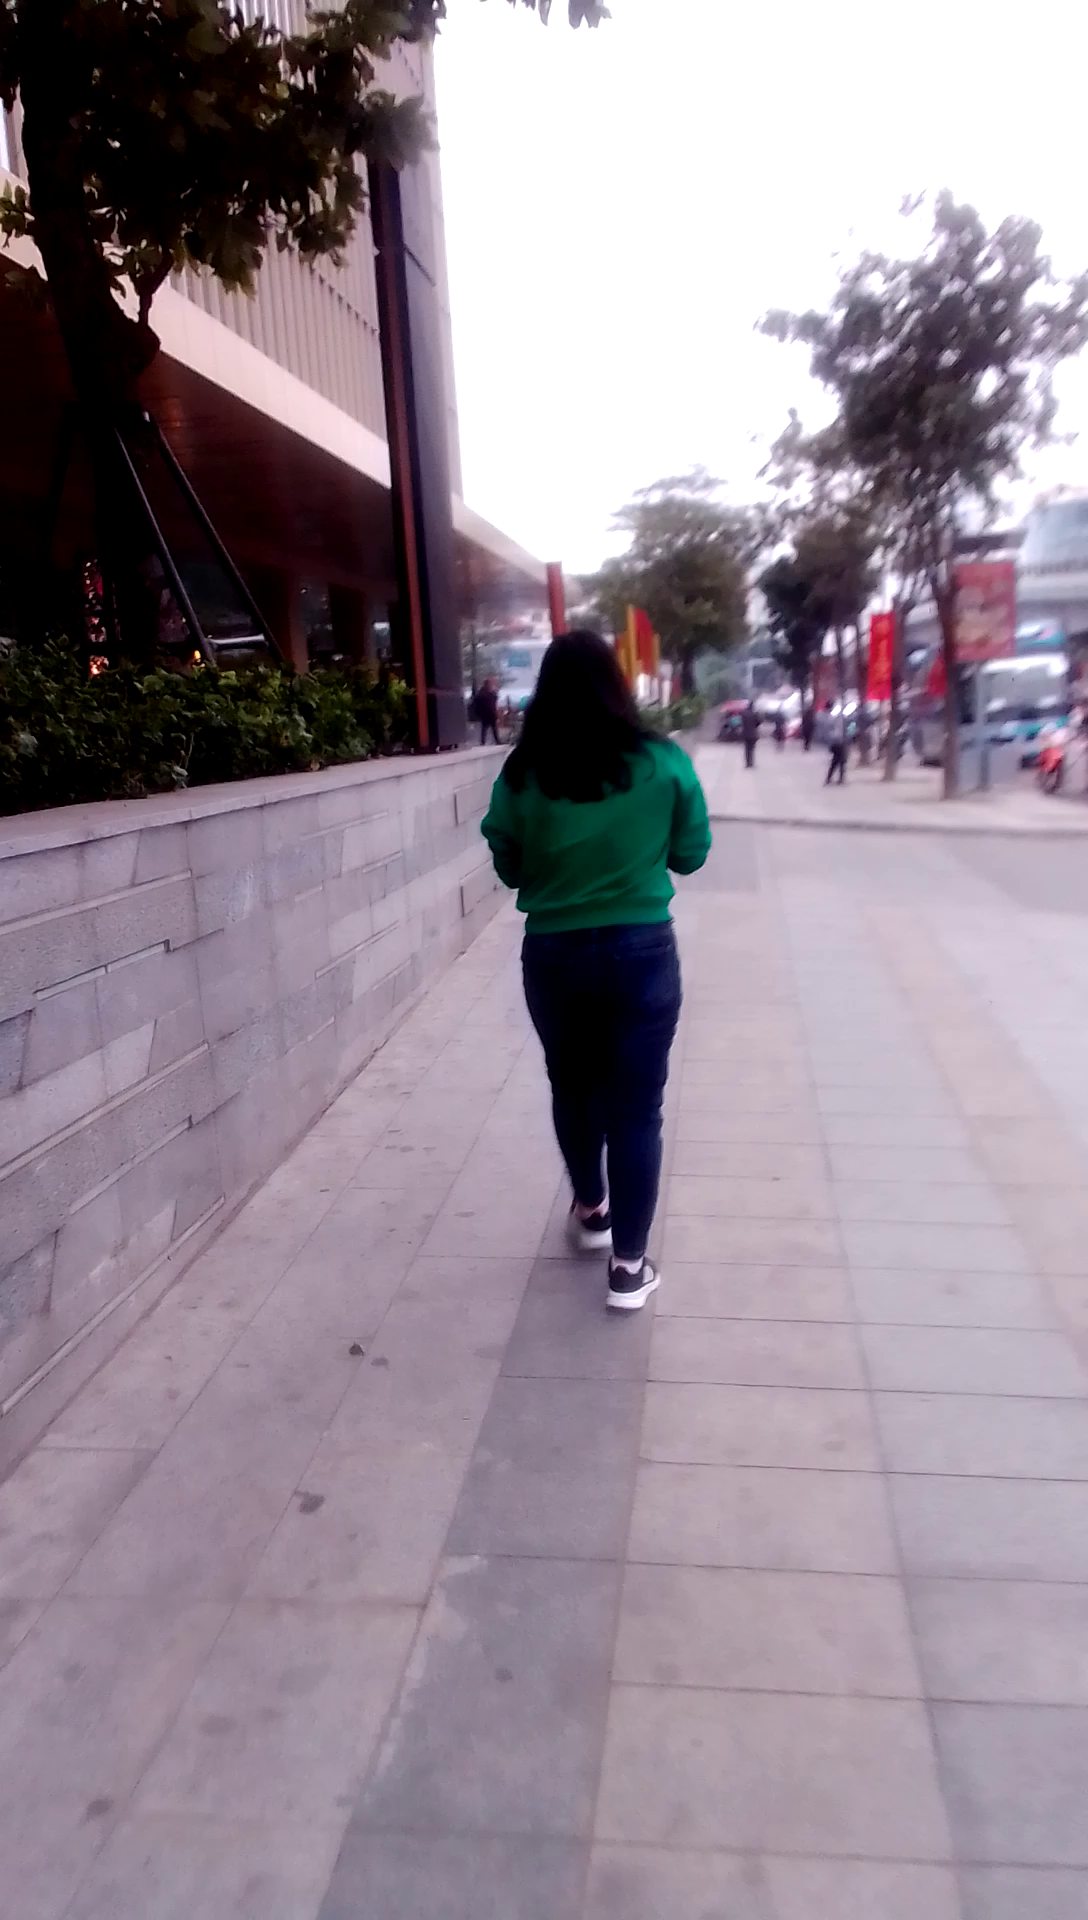

In [217]:
left_vid, left_counts, left_fps, left_sample = load_video(left_video_path, -90)
left_sample

40 29.880974119756303


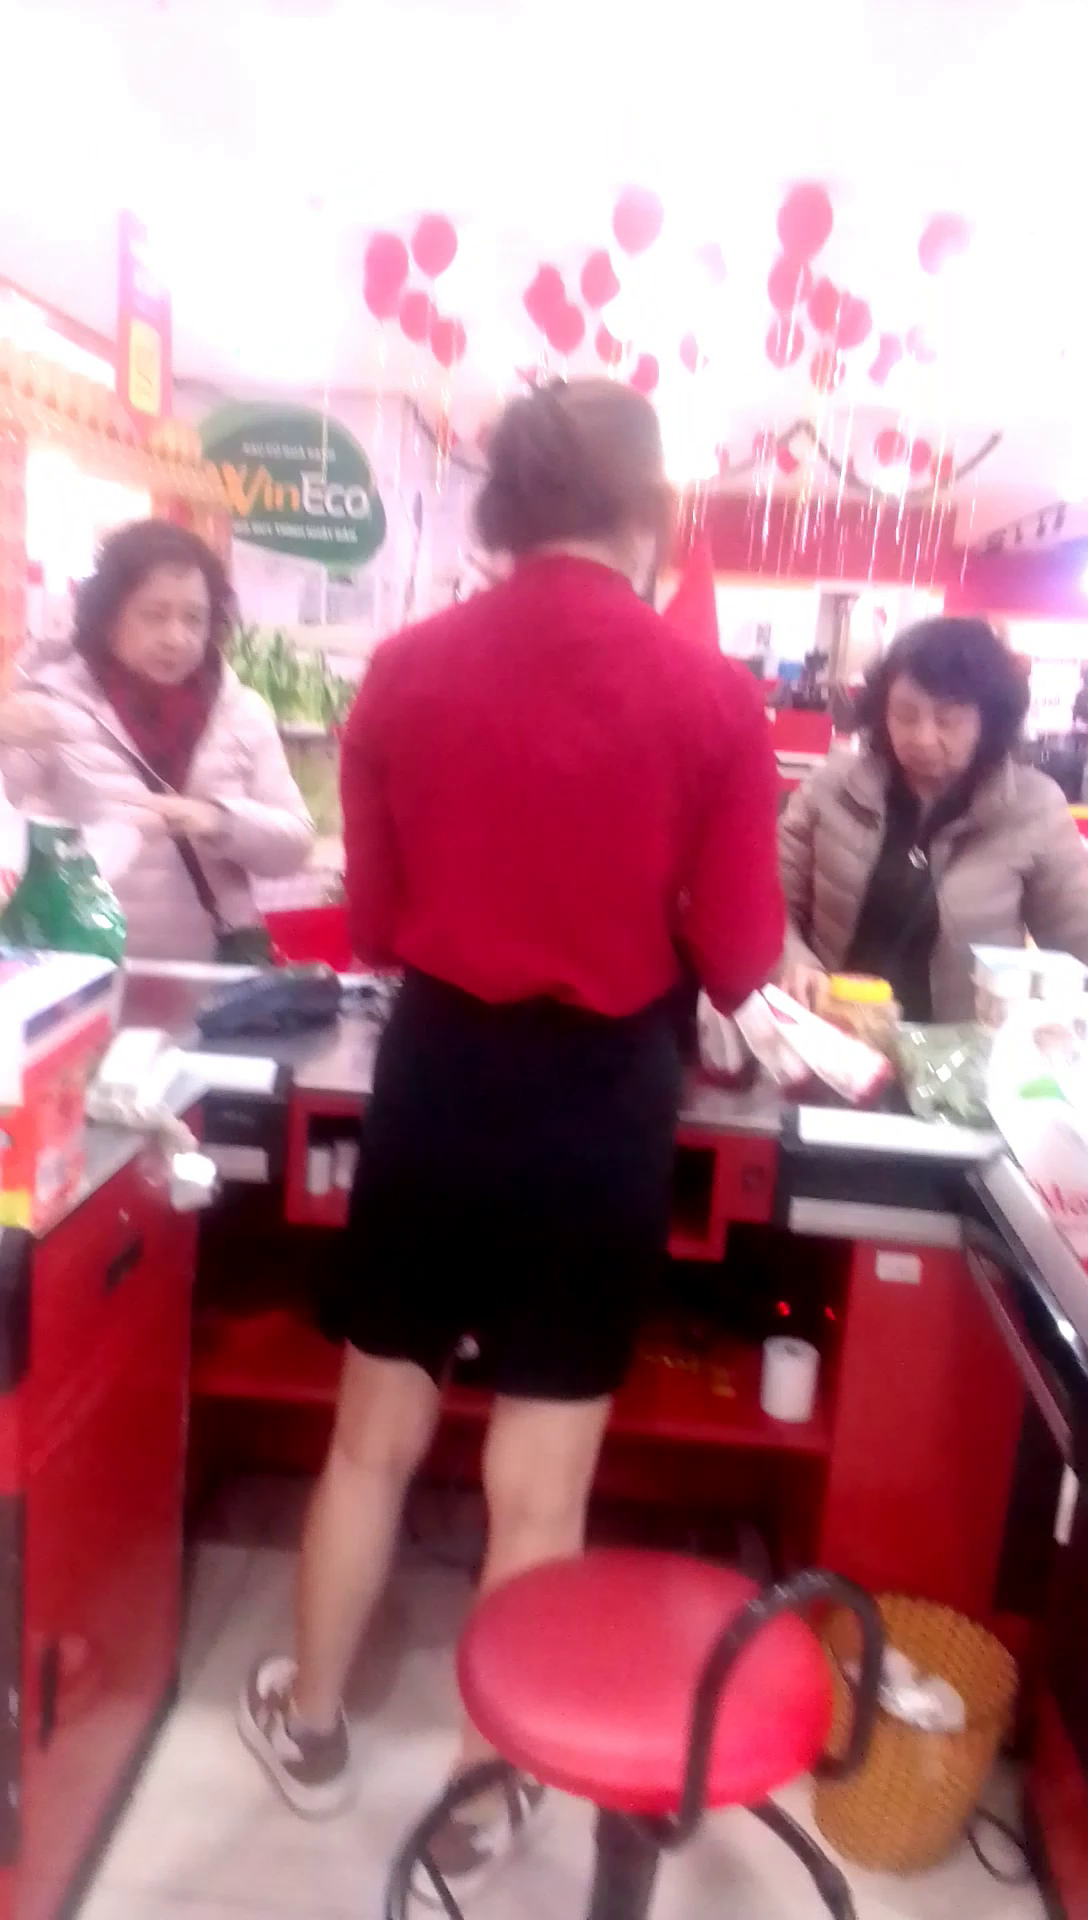

In [218]:
right_vid, right_counts, right_fps, right_sample = load_video(right_video_path, -90)
right_sample

In [219]:
if left_sample.width  > right_sample.width:
    left_sample = left_sample.resize((right_sample.width, right_sample.height))
elif left_sample.width  < right_sample.width:
    right_sample = right_sample.resize((left_sample.width, left_sample.height))

In [220]:
print(left_sample.width, right_sample.width)

1088 1088


In [221]:
### Function to calculate Bouding Box Area and Range from Center

def center(bbox):
    center_x = (bbox[2] + bbox[0])/2
    center_y = (bbox[3] + bbox[1])/2
    center = [center_x, center_y]
    return center

def dfc(pic, bbox):
    pic_width = pic.width
    pic_height = pic.height
    
    pic_center = center([0,0, pic_width, pic_height])
    bbox_center = center(bbox)
    
    x_dif = bbox_center[0] - pic_center[0]
    y_dif = bbox_center[1] - pic_center[1]
    bbox_width = bbox[2] - bbox[0]
    bbox_height = bbox[3] - bbox[1] 
    distance = math.sqrt(x_dif * x_dif + y_dif * y_dif)
    area = abs(bbox_width * bbox_height)
    return distance, area

In [222]:
def bodyRatio(kp):
    ls = kp[0][5]
    rs = kp[0][6]

    lh = kp[0][11]
    rh = kp[0][12]

    la = kp[0][15]
    ra = kp[0][16]

    def legToBack(s, h, a):
        return (a-h)/(h-s)

    def hipToShoulder(lh, rh, ls, rs):
        return (rh-lh)/(rs-ls)

    if la[1] >= ra[1]:
        legRatio = legToBack(ls[1], lh[1], la[1])
    else:
        legRatio = legToBack(rs[1], rh[1], ra[1])
        
    hipRatio = hipToShoulder(lh[0], rh[0], ls[0], rs[0])
    
    leg_back = legRatio.item()
    hip_shoulder = hipRatio.item()
    
    # Type one
    #     score = round(
    #         (abs(leg_back) - 1 + (abs(hip_shoulder)-0.5)*4),
    #     3)*1000
    #     print(score, leg_back, hip_shoulder)
    
    # Type two
    # score = round(abs(1-(leg_back*hip_shoulder-0.08))*1000, 1)
    
    # Type three
    score = int(round(leg_back + 2 * hip_shoulder, 2)*100)
    
    points = [
        [ls[0].item(), ls[1].item()],
        [rs[0].item(), rs[1].item()],
        [lh[0].item(), lh[1].item()], 
        [rh[0].item(), rh[1].item()], 
        [la[0].item(), la[1].item()], 
        [ra[0].item(), ra[1].item()]
    ]
    
    print(score, leg_back, hip_shoulder)
    
    return score, leg_back, hip_shoulder, points

In [223]:
from PIL import ImageDraw, ImageFont

def drawMarkers(coordinates, image):
    marker_font = ImageFont.truetype("Roboto-Bold.ttf", 10)
    
    sample = image.copy()
    draw = ImageDraw.Draw(sample) 
            
    for index, point in enumerate(coordinates):
        label = index + 1
        radius = 10

        draw.ellipse(
            [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)],
            fill="#40389F",
            outline="#ffffff",
            width=1
        )

        draw.text(
            (point[0]-3, point[1]-5),
            str(label),
            fill="#FAFF00",
            font=marker_font,
            align="center"
        )
    return sample

def addData(image, data): 
    width = image.width
    sample = image.copy()
    draw = ImageDraw.Draw(sample) 
    top_margin = 100

    draw.rectangle(
        [(width/2-200,top_margin), (width/2+200, top_margin+130)], 
        fill="#40389F", 
        outline=None
    )

    title_font = ImageFont.truetype("Roboto-Bold.ttf", 31)
    data_font = ImageFont.truetype("Roboto-Bold.ttf", 41)

    draw.text(
        (width/2-120,top_margin+20),
        "Body Matrix Score",
        fill="#FAFF00",
        font=title_font,
        align="center"
    )

    draw.text(
        (width/2-40,top_margin+60),
        data,
        fill="#FAFF00",
        font=data_font,
        align="center"
    )


    return sample

In [224]:
### Loading Keypoints Models
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights

weights = KeypointRCNN_ResNet50_FPN_Weights.COCO_V1
model =  keypointrcnn_resnet50_fpn(weights=weights)
transforms = weights.transforms()

model.eval().to("cpu")

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [225]:
### Frame Keypoints Prediction and Visualization
import torch
from torchvision.utils import draw_keypoints, draw_bounding_boxes
from torchvision.transforms.functional import pil_to_tensor

def detect(pos, frame):
    ### Make Predictions on Frame
    body_matrix = transforms(frame)
    predictions = model([body_matrix.to("cpu")])

    ### Extract Boxes, Scores and Keypoints from frame
    boxes = predictions[0]['boxes']
    keypoints = predictions[0]['keypoints']
    scores = predictions[0]['scores']

    ### Filter for the main Bounding Box and Keypoints
    idx = torch.where(scores > min_accuracy)
    
    main_boxes = torch.unsqueeze(boxes[idx], dim=1)
    index = 0
    max_area = 0
    max_distance = frame.width/3

    for selector, box in enumerate(main_boxes):
        bbox = [
            box[0][0].item(), 
            box[0][1].item(),
            box[0][2].item(),
            box[0][3].item()
        ]
        
        distance, area = dfc(frame, bbox) 
        if distance < max_distance and area > max_area:
            max_area = area
            index = selector
            # print("Selected", area, selector, distance)
        # else:
            # print("Not selected", area, selector, distance)
    
    bx = torch.unsqueeze(boxes[idx][index], dim=0)
    kp = torch.unsqueeze(keypoints[idx][index], dim=0)
    score, legRatio, hipRatio, points = bodyRatio(kp)
    
    labels = [f'SCORE: {score}']
    # print(f"Main Index: {main_index}, Score: {score}")
    
    ### Draw Keypoints and Bounding Boxes
    tensor_image = pil_to_tensor(frame)
    ### keypoints_image = draw_keypoints(tensor_image, kp, colors="yellow", radius=3)
    
    final_image = draw_bounding_boxes(
        tensor_image, 
        bx, 
        colors="blue", 
        fill=True, 
    )
    
    pil_image = to_pil_image(final_image)
    points_image = drawMarkers(points, pil_image)
    final_image = addData(points_image, f"{score}")

    return final_image, score

In [226]:
cd "$output_folder"

/Users/troydo42/Desktop/Body_Matrixes/outputs


In [227]:
mkdir "$date"

mkdir: 2022_12_14: File exists


In [228]:
cd "$date"

/Users/troydo42/Desktop/Body_Matrixes/outputs/2022_12_14


In [229]:
from PIL import Image

def stitch(left_frame, right_frame):
    left_cal, left_score = detect("left", left_frame)
    right_cal, right_score = detect("right", right_frame)

    width = left_cal.width + right_cal.width
    height = left_cal.height

    left_right = Image.new("RGB",(width, height))
    left_right.paste(im=left_cal, box=(0,0))
    left_right.paste(im=right_cal, box=(left_cal.width, 0))
    return left_right, left_score, right_score

output, left_score, right_score = stitch(left_sample, right_sample)

283 1.6148145198822021 0.6100001335144043
284 1.6836367845535278 0.577114462852478


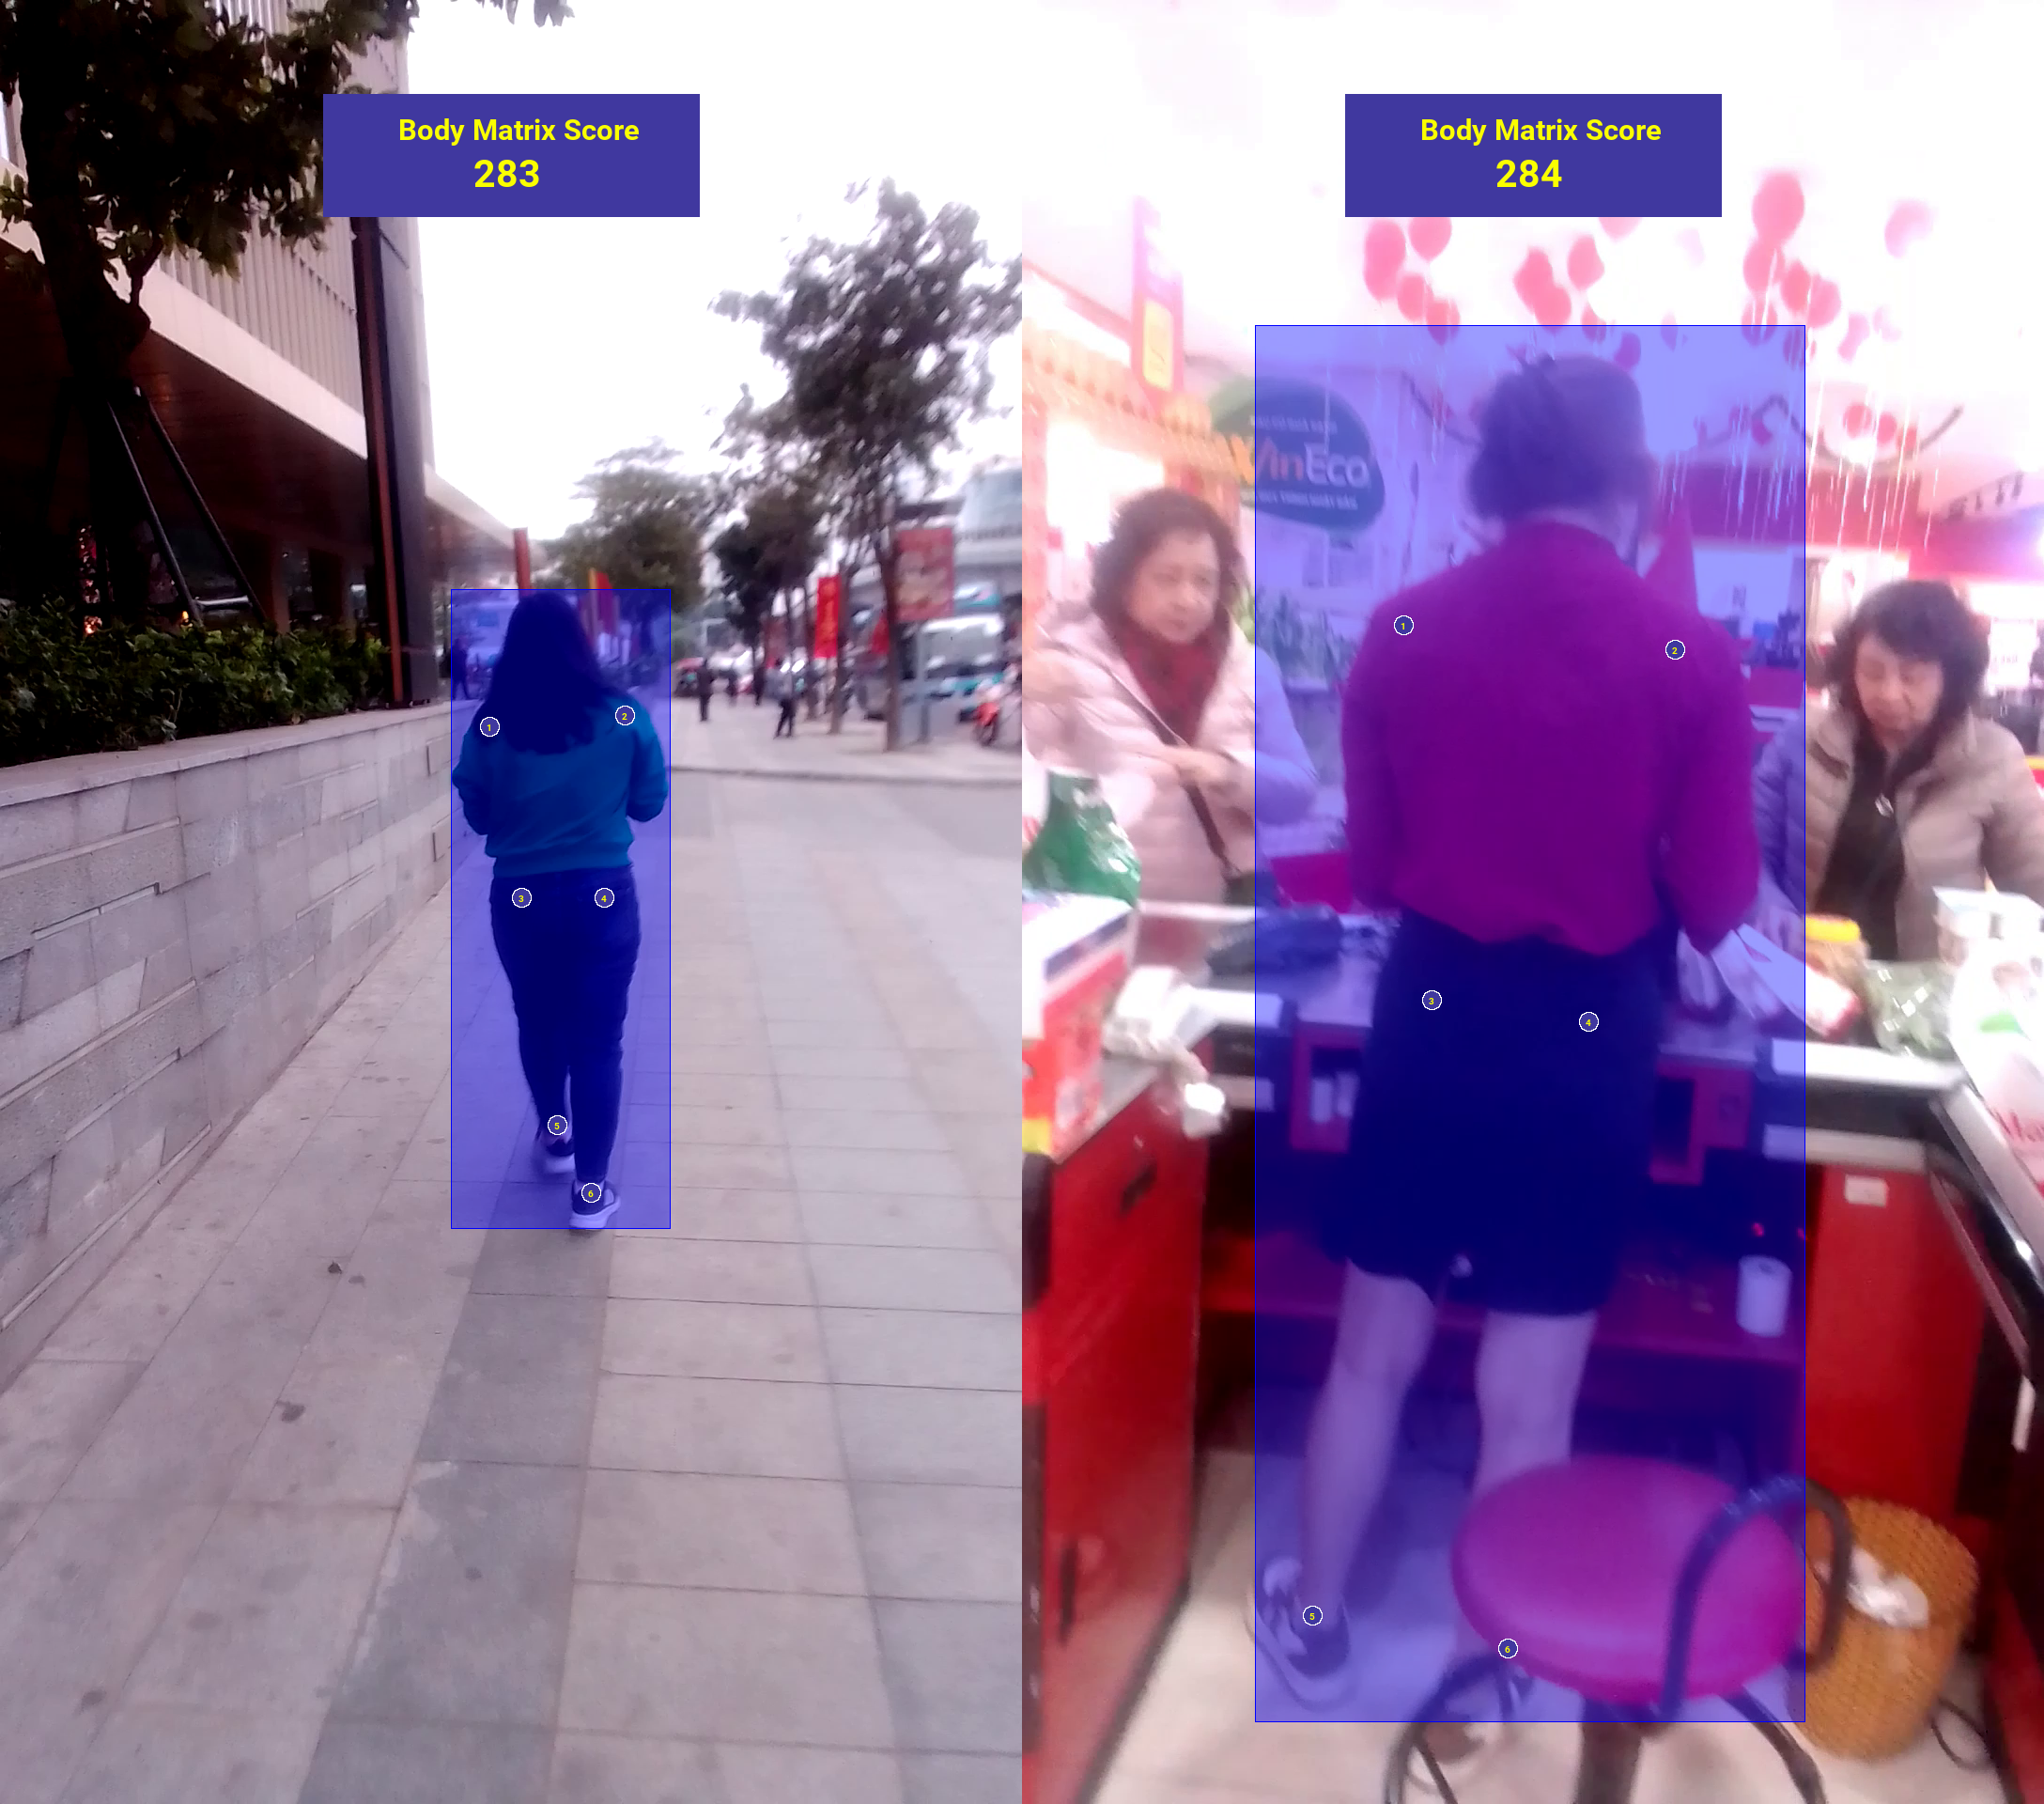

In [230]:
output

In [231]:
output_image = str(right_score) + "_" + str(left_score) +"_Body_Matrix_Scores_" + left_file[0:-4] + "_vs_" + right_file[0:-4] + ".png"
output.save(output_image)

In [232]:
def video_processing(left_vid, right_vid):
    frame_counts = min(len(left_vid), len(right_vid))
    container = av.open(output_video, mode="w")
    stream = container.add_stream("mpeg4", rate=math.floor(left_fps))
    stream.width = output.width
    stream.height = output.height
    left_sample_scores = []
    right_sample_scores = []
    
    def encode(image):
        frame = av.VideoFrame.from_image(image)
        for packet in stream.encode(frame):
            container.mux(packet)
    
    for idx in range(frame_counts):
        print(f"Processing {idx+1} of {frame_counts} ", end="\r")
        
        left_frame = to_pil_image(left_vid[idx])
        left_frame = left_frame.rotate(-90, expand=True)
        
        right_frame = to_pil_image(right_vid[idx])
        right_frame = right_frame.rotate(-90, expand=True)
        
        stitched_frame, left_score, right_score = stitch(left_frame, right_frame)
        left_sample_scores.append(left_score)
        right_sample_scores.append(right_score)
        encode(stitched_frame)
    
    container.close()
    return left_sample_scores, right_sample_scores

In [233]:
output_video = "_Body_Matrix_Scores_" + left_file[0:-4] + "_vs_" + right_file[0:-4] + ".mp4"

In [ ]:
left_sample_scores, right_sample_scores = video_processing(left_vid, right_vid)

270 1.496551752090454 0.6017698049545288
278 1.651078701019287 0.562188982963562
275 1.5098029375076294 0.6194684505462646
267 1.5958187580108643 0.5384612679481506
273 1.5032684803009033 0.6126126050949097
287 1.7370370626449585 0.5658536553382874
274 1.5098040103912354 0.6146789193153381
275 1.6605165004730225 0.5463413000106812
275 1.5359491109848022 0.6090909242630005
276 1.6562504768371582 0.5539215207099915
273 1.5490202903747559 0.5929203033447266
275 1.6280709505081177 0.5603866577148438
277 1.5562905073165894 0.6090912818908691
284 1.6836367845535278 0.577114462852478
277 1.5562918186187744 0.6090909242630005
283 1.6763631105422974 0.5754716992378235
272 1.5099338293075562 0.6071426272392273
297 1.8250946998596191 0.5707544684410095
269 1.4533332586288452 0.6203701496124268
296 1.8052432537078857 0.578947126865387
261 1.375839352607727 0.6146788597106934
281 1.6347520351409912 0.5882351994514465
252 1.347220540046692 0.5909088850021362
280 1.626334309577942 0.5865384936332703


In [ ]:
print(left_sample_scores)

In [ ]:
print(right_sample_scores)

In [ ]:
import numpy as np
import seaborn as sns

def best_scores(array):
    scores = []
    for x in array:
        if x > 350 or x <  200:
            pass
        else:
            scores.append(x)
    updated_scores = remove_outlier(scores)
    np_scores = np.array(updated_scores)
    mean = np.mean(np_scores)
    medium = np.mean(np_scores)
    minim = np.min(np_scores)
    maxim = np.max(np_scores)
    histogram_scores = np.histogram(np_scores, bins=10)
    sns.distplot(np_scores, hist=True)
    
    return mean, medium, minim, maxim
    

In [ ]:
best_scores(left_sample_scores)

In [ ]:
best_scores(right_sample_scores)